# Estimating intrinsic causal influences in real-world examples

This notebook demonstrates the usage of the [intrinsic causal influence (ICC) method](https://proceedings.mlr.press/v238/janzing24a.html), a way to estimate causal influence in a system. A common question in many applications is: "What is the causal influence of node X on node Y?" Here, "causal influence" can be defined in various ways. One approach could be to measure the interventional influence, which asks, "How much does node Y change if I intervene on node X?" or, from a more feature relevance perspective, "How relevant is X in describing Y?"

In the following we focus on a particular type of causal influence, which is based on decomposing the generating process into mechanisms in place at each node, formalized by the respective causal mechanism. Then, ICC quantifies for each node the amount of uncertainty of the target that can be traced back to the respective mechanism. Hence, nodes that are deterministically computed from their parents obtain zero contribution. This concept may initially seem complex, but it is based on a simple idea:

Consider a chain of nodes: X -> Y -> Z. Y is more informative about Z than X, as Y directly determines Z and also incorporates all information from X. It is obvious that when intervening on either X or Y, Y has a more significant impact on Z. But, what if Y is just a rescaled copy of X, i.e., $Y = a \cdot X$? In this case, Y still has the largest interventional influence on Z, but it is not adding any new information on top of X. The ICC method, on the other hand, would attribute 0 influence to Y as it only passes on what it inherits from X. 

The idea behind ICC is not to estimate the contribution of observed upstream nodes to the target node, but instead to attribute the influence of their noise terms. Since we model each node as a functional causal model of the form $X_i = f_i(PA_i, N_i)$, we aim to estimate the contribution of the $N_i$ terms to the target. In the previous example, we have deterministic relationships with zero noise, i.e., the intrinsic influence is 0. This type of attribution is only possible when we explicitly model our causal relationships using functional causal models, as we do in the GCM module.

In the following, we will look at two real-world examples where we apply ICC.

## Intrinsic influence on car MPG consumption

In the first example, we use the famous [MPG data set](https://archive.ics.uci.edu/dataset/9/auto+mpg), which contains different features that are used for the prediction of miles per gallon (mpg) of a car engine. Let's say our task is to improve the design process where we need a good understanding of the influences of our variables on the mpg consumption. The relationship between these features can be modeled as a graphical causal model. For this, we follow the causal graph defined in the [work by Wang et al.](https://ieeexplore.ieee.org/document/8585647) and remove all nodes that have no influence on MPG. This leaves us with the following graph:

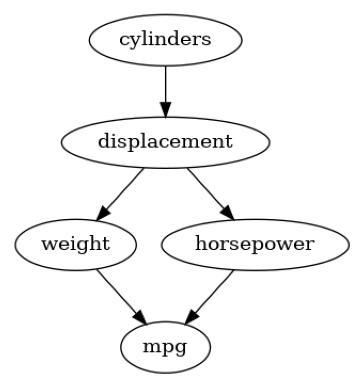

In [1]:
import pandas as pd
import networkx as nx
import numpy as np

from dowhy import gcm
from dowhy.utils.plotting import plot, bar_plot

# Load a modified version of the Auto MPG data: Quinlan,R.. (1993). Auto MPG. UCI Machine Learning Repository. https://doi.org/10.24432/C5859H.
auto_mpg_data = pd.read_csv("datasets/auto_mpg.csv", index_col=0)

mpg_graph = nx.DiGraph([('cylinders', 'displacement'), 
                        ('cylinders', 'displacement'),
                        ('displacement', 'weight'),
                        ('displacement', 'horsepower'),
                        ('weight', 'mpg'),
                        ('horsepower', 'mpg')])

plot(mpg_graph)

Seeing this graph, we can expect some strong confounders between the nodes, but nevertheless, we will see that the ICC method still provides non-trivial insights.

Let's define the corresponding structural causal model and fit it to the data:

In [2]:
scm_mpg = gcm.StructuralCausalModel(mpg_graph)
gcm.auto.assign_causal_mechanisms(scm_mpg, auto_mpg_data)
gcm.fit(scm_mpg, auto_mpg_data)

Fitting causal models:   0%|          | 0/5 [00:00<?, ?it/s]

Fitting causal mechanism of node cylinders:   0%|          | 0/5 [00:00<?, ?it/s]

Fitting causal mechanism of node displacement:   0%|          | 0/5 [00:00<?, ?it/s]

Fitting causal mechanism of node weight:   0%|          | 0/5 [00:00<?, ?it/s]      

Fitting causal mechanism of node horsepower:   0%|          | 0/5 [00:00<?, ?it/s]

Fitting causal mechanism of node horsepower:  80%|████████  | 4/5 [00:00<00:00, 23.46it/s]

Fitting causal mechanism of node mpg:  80%|████████  | 4/5 [00:00<00:00, 23.46it/s]       

Fitting causal mechanism of node mpg: 100%|██████████| 5/5 [00:00<00:00, 28.62it/s]

Optionally, we can get some insights into the performance of the causal mechanisms by using the evaluation method:

In [3]:
print(gcm.evaluate_causal_model(scm_mpg, auto_mpg_data, evaluate_invertibility_assumptions=False, evaluate_causal_structure=False))

Evaluating causal mechanisms...:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating causal mechanisms...: 100%|██████████| 5/5 [00:00<00:00, 429.87it/s]

Evaluated the performance of the causal mechanisms and the overall average KL divergence between generated and observed distribution. The results are as follows:

==== Evaluation of Causal Mechanisms ====
The used evaluation metrics are:
- KL divergence (only for root-nodes): Evaluates the divergence between the generated and the observed distribution.
- Mean Squared Error (MSE): Evaluates the average squared differences between the observed values and the conditional expectation of the causal mechanisms.
- Normalized MSE (NMSE): The MSE normalized by the standard deviation for better comparison.
- R2 coefficient: Indicates how much variance is explained by the conditional expectations of the mechanisms. Note, however, that this can be misleading for nonlinear relationships.
- F1 score (only for categorical non-root nodes): The harmonic mean of the precision and recall indicating the goodness of the underlying classifier model.
- (normalized) Continuous Ranked Probability Score (CRPS):

After defining our structural causal model, we can now obtain more insights into what factors influence fuel consumption. As a first insight, we can estimate the direct arrow strength of the connections weight -> mpg and horsepower -> mpg. Note that by default, the arrow strength method measures the influence with respect to the variance.

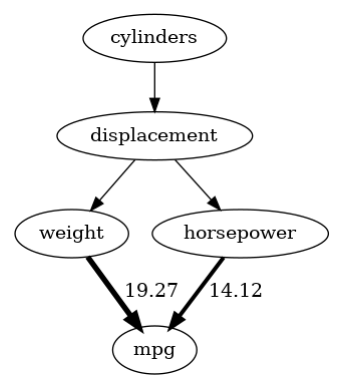

In [4]:
arrow_strengths_mpg = gcm.arrow_strength(scm_mpg, target_node='mpg')
gcm.util.plot(scm_mpg.graph, causal_strengths=arrow_strengths_mpg)

As we see here, the weight has a much higher influence on the variance in mpg than horsepower does.

While knowing how much the direct parents influence our node of interest provides some valuable insights, the weight and horsepower might only just inherit information from their common parent. To distinguish between the information inherited from the parent and their own contribution, we apply the ICC method:

In [5]:
iccs_mpg = gcm.intrinsic_causal_influence(scm_mpg, target_node='mpg')

Evaluating set functions...:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating set functions...:  50%|█████     | 16/32 [00:02<00:02,  6.36it/s]

Evaluating set functions...:  75%|███████▌  | 24/32 [00:07<00:02,  2.87it/s]

Evaluating set functions...:  88%|████████▊ | 28/32 [00:12<00:02,  1.79it/s]

Evaluating set functions...: 100%|██████████| 32/32 [00:14<00:00,  1.74it/s]

Evaluating set functions...: 100%|██████████| 32/32 [00:14<00:00,  2.13it/s]

For a better interpretation of the results, we convert the variance attribution to percentages by normalizing it over the total sum.

In [6]:
def convert_to_percentage(value_dictionary):
    total_absolute_sum = np.sum([abs(v) for v in value_dictionary.values()])
    return {k: abs(v) / total_absolute_sum * 100 for k, v in value_dictionary.items()}

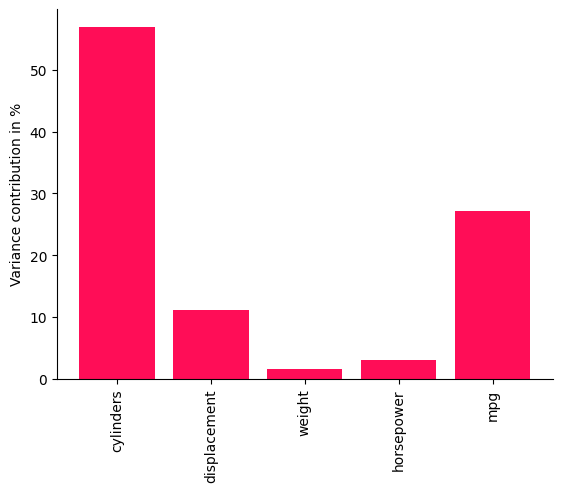

In [7]:
bar_plot(convert_to_percentage(iccs_mpg), ylabel='Variance contribution in %')

It turns out that the number of cylinders already explains a large fraction of the fuel consumption and the intermediate nodes like displacement, horsepower, and weight mostly inherit uncertainty from their parents. This is because, although weight and horsepower are the more direct predictors of mpg, they are mostly determined by displacement and cylinders. This gives some useful insights for potential optimizations. As we also see with the contribution of mpg itself, roughly 1/4 of the variance of mpg remains unexplained by all of the above factors, which may be partially due to model inaccuracies.

While the model evaluation showed that there are some inaccuracies with respect to the KL divergence between the generated and observed distributions, we see that ICC still provides non-trivial results in the sense that the contributions differ significantly across nodes and that not everything is simply attributed to the target node itself.

> Note that estimating the contribution to the variance of the target in ICC can be seen as a nonlinear version of ANOVA that incorporates the causal structure.

## Intrinsic influence on river flow

In the next example, we look at different recordings taken of the river flows ($m^3/s$) at a 15 minute frequency across 5 different measuring stations in England at Henthorn, New Jumbles Rock, Hodder Place, Whalley Weir and Samlesbury. Here, obtaining a better understanding of how the river flows behave can help to plan potential mitigation steps to avoid overflows. The data is taken from the [UK Department for Environment Food & Rural Affairs website](https://environment.data.gov.uk/hydrology/explore). Here is a map of the rivers:

<img src="./river-map.jpg" width="600"/>

New Jumbles Rock lies at a confluence point of the 3 rivers passing Henthorn, Hodder Place, and Whalley Weir and New Jumbles Rock flows into Samlesbury. The water passing a certain measuring station is certainly a mixture of some fraction of the amount observed at the next stations further upstream plus some amount contributed by streams and little rivers entering the river in between. This defines our causal graph as:

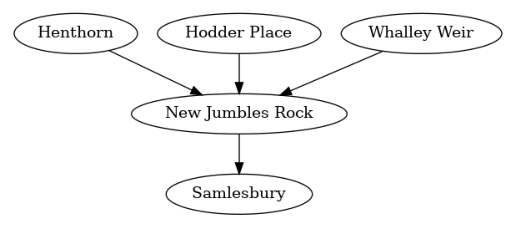

In [8]:
river_graph = nx.DiGraph([('Henthorn', 'New Jumbles Rock'), 
                          ('Hodder Place', 'New Jumbles Rock'), 
                          ('Whalley Weir', 'New Jumbles Rock'), 
                          ('New Jumbles Rock', 'Samlesbury')])

plot(river_graph)

In this setting, we are interested in the causal influence of the upstream rivers on the Samlesbury river. Similar to the example before, we would expect these nodes to be heavily confounded by, e.g., the weather. That is, the true graph is more likely to be along the lines of:

<img src="./river-confounded.png" width="400"/>

Nevertheless, we still expect the ICC algorithm to provide some insights into the contribution to the river flow of Samlesbury, even with the hidden confounder in place:

Fitting causal models:   0%|          | 0/5 [00:00<?, ?it/s]

Fitting causal mechanism of node Henthorn:   0%|          | 0/5 [00:00<?, ?it/s]

Fitting causal mechanism of node New Jumbles Rock:   0%|          | 0/5 [00:00<?, ?it/s]

Fitting causal mechanism of node Hodder Place:   0%|          | 0/5 [00:00<?, ?it/s]    

Fitting causal mechanism of node Whalley Weir:   0%|          | 0/5 [00:00<?, ?it/s]

Fitting causal mechanism of node Samlesbury:   0%|          | 0/5 [00:00<?, ?it/s]  

Fitting causal mechanism of node Samlesbury: 100%|██████████| 5/5 [00:00<00:00, 369.38it/s]

Evaluating set functions...:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating set functions...:  75%|███████▌  | 24/32 [00:00<00:00, 188.24it/s]

Evaluating set functions...: 100%|██████████| 32/32 [00:00<00:00, 240.35it/s]

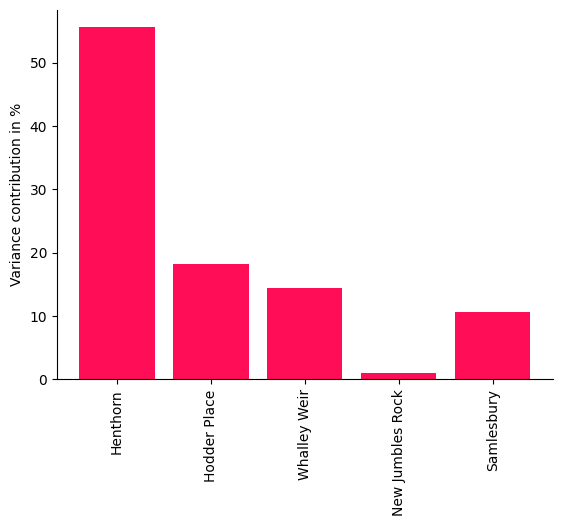

In [9]:
river_data = pd.read_csv("river.csv", index_col=False)

scm_river = gcm.StructuralCausalModel(river_graph)
gcm.auto.assign_causal_mechanisms(scm_river, river_data)
gcm.fit(scm_river, river_data)

iccs_river = gcm.intrinsic_causal_influence(scm_river, target_node='Samlesbury')
bar_plot(convert_to_percentage(iccs_river), ylabel='Variance contribution in %')

Interestingly, the intrinsic contribution of New Jumbles Rock on Samlesbury is small, although the interventional effect on New Jumbles Rock would certaintly have a large effect. This illustrates that ICC does not measure influence in the sense of the strength of a treatment effect and points out here that New Jumbles Rock simply passes the flow onto Samlesbury. The contribution by Samlesbury itself represents the (hidden) factors that are not captured. Even though we can expect the nodes to be heavily confounded by the weather, the analysis still provides some interesting insights which we only obtain by carefully distinguishing between influences that were just inherited from the parents and 'information' that is newly added by the node.